In [3]:
!pip install torch==1.6.0
!pip install opencv-python
!pip install torchvision==0.2.2
!pip install albumentations
!pip install tensorflow
!pip install pytorch-lightning

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 748.8 MB 16 kB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 49.5 MB 29.4 MB/s 
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 64 kB 5.6 MB/s 
     |████████████████████████████████| 52 kB 3.7 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user i

In [23]:
from pathlib import Path
import numpy as np
import pandas as pd
import typing as tp
import yaml
import random
import os
import sys
import soundfile as sf
import librosa
import cv2
import matplotlib.pyplot as plt
import time
import glob

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# import resnest.torch as resnest_torch

from torchvision import models

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
# from resnet import ResNet, Bottleneck

from albumentations.core.transforms_interface import DualTransform, BasicTransform
import albumentations as A


from sklearn.model_selection import StratifiedKFold

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## util

In [24]:
config_set = {
    'dataset': {
          'name': 'SpectrogramDataset',
          'params': {
            'img_size': 224, 
            'melspectrogram_parameters': {
              'n_mels': 128, 
              'fmin': 50, 
              'fmax': 15000, 
            }
      }
    },
    'loader': {
      'train': {
        'batch_size': 6,
        'shuffle': True,
        'num_workers': 2,
        'pin_memory': True,
        'drop_last': True,
      },
      'valid': {
        'batch_size': 2,
        'shuffle': False,
        'num_workers': 2,
        'pin_memory': True,
        'drop_last': True,
      }
    }
}
SEED=100
PERIOD = 5
SPECIES_NUM = 24
EPOCH = 50
OUTPUT_DIR = './output/'
HOP_LEN = 512
SR = 48000

In [27]:
transform = A.Compose([
    A.GaussNoise(p=0.2),
])

In [28]:
config = config_set

In [29]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
set_seed(SEED)

In [30]:
INPUT_ROOT = Path("/home/knikaido/work/Rainforest-Connection/data")
RAW_DATA = INPUT_ROOT / "rfcx-species-audio-detection"
TRAIN_AUDIO_DIR = RAW_DATA / "train"
# TRAIN_RESAMPLED_AUDIO_DIRS = [
#   INPUT_ROOT / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
# ]
TEST_AUDIO_DIR = RAW_DATA / "test"

In [31]:
train_gby = pd.read_pickle(RAW_DATA / "train_gby_mel.pkl")
train_gby.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,name
0,003bec244,[14],[1],[44.544],[2531.25],[45.1307],[5531.25],/home/knikaido/work/Rainforest-Connection/Git/...
1,006ab765f,[23],[1],[39.9615],[7235.16],[46.0452],[11283.4],/home/knikaido/work/Rainforest-Connection/Git/...
2,007f87ba2,[12],[1],[39.135999999999996],[562.5],[42.272],[3281.25],/home/knikaido/work/Rainforest-Connection/Git/...
3,0099c367b,[17],[4],[51.4206],[1464.26],[55.1996],[4565.04],/home/knikaido/work/Rainforest-Connection/Git/...
4,009b760e6,[10],[1],[50.0854],[947.461],[52.5293],[10852.7],/home/knikaido/work/Rainforest-Connection/Git/...


In [32]:
def mono_to_color(
    X: np.ndarray, mean=None, std=None,
    norm_max=None, norm_min=None, eps=1e-6
):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [33]:
class SpectrogramTrainDataset(data.Dataset):
    def __init__(
        self,
        gby_df: pd.DataFrame,
        setting: tp.Dict
    ):
        self.img_size = setting['img_size']
        self.melspectrogram_parameters = setting['melspectrogram_parameters']
        
        self.gby_df = gby_df

    def __len__(self):
        return len(self.gby_df)

    def __getitem__(self, idx: int):
        
        mel_path = self.gby_df['name'][idx]
        train_element = self.gby_df.iloc[idx]
        
        melspec = np.load(mel_path)
        
        len_mel = melspec.shape[1]
        effective_length = int(SR * PERIOD / HOP_LEN)

        tmin_list = train_element['t_min']
        tmax_list = train_element['t_max']
        
        #時間かかる
        end_flag = False
        while(end_flag==False):
            start = np.random.randint(len_mel - effective_length)
            end = start + effective_length
            for i in range(len(tmin_list)):
                tmin = int(tmin_list[i] * SR / HOP_LEN)
                tmax = int(tmax_list[i] * SR / HOP_LEN)
                if( (start < tmin and tmin < end) or (start < tmax and tmax < end) ):
                    end_flag = True
                    break

#         tmin = int(tmin_list[0] * SR / HOP_LEN)
#         start_min = max(0, tmin - effective_length)
#         start_max = min(tmin, len_mel - effective_length)
#         start = np.random.randint(start_min, start_max)
#         end = start + effective_length 
        
        melspec = melspec[:, start:end]

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = transform(image=image)
        image = image["image"]
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)
        
        label = np.zeros(SPECIES_NUM, dtype="f")
        label[train_element['species_id'][0]] = 1

        return image, label

In [34]:
species_id_head_list = []
for l_ in train_gby['species_id']:
    species_id_head_list.append(l_[0])

In [35]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
train_files = []
val_files = []

In [36]:
for fold_id, (train_index, val_index) in enumerate(skf.split(train_gby, species_id_head_list)):
    # Picking only first fold to train/val on
    # This means loss of 20% training data
    # To avoid this, you can train 5 different models on 5 folds and average predictions
    if fold_id == 0:
        train_data = train_gby.iloc[train_index]
        valid_data = train_gby.iloc[val_index]

In [37]:
train_data.reset_index(drop=True, inplace=True)
valid_data.reset_index(drop=True, inplace=True)

In [38]:
def get_criterion():
    pos_weights = torch.ones(SPECIES_NUM)
    pos_weights = pos_weights * SPECIES_NUM
    loss_function = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    return loss_function

In [39]:
class LitModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
        self.encoder.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, SPECIES_NUM)
        )
        
        self.criterion = get_criterion()
        
    def forward(self, x):
        x_out = self.encoder(x)
        return x_out
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001, momentum=0.9)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.encoder(x)    
        loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.encoder(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    
    def validation_epoch_end(self, validation_step_outputs):
        mean_loss = torch.stack([x for x in validation_step_outputs]).mean()
        print('valid_epoch_loss = ', mean_loss)
        self.log('valid_epoch_loss', mean_loss, prog_bar=True, logger=True)
#         tqdm.write('Dice: \t%.3f' % mean_loss)
        return mean_loss

In [40]:
train_dataset = SpectrogramTrainDataset(train_data, config["dataset"]["params"])
valid_dataset = SpectrogramTrainDataset(valid_data, config["dataset"]["params"])

In [41]:
train_loader = data.DataLoader(train_dataset, **config["loader"]["train"])
valid_loader = data.DataLoader(valid_dataset, **config["loader"]["valid"])

In [52]:
for batch_idx, (data_, target) in enumerate(train_loader):
    break

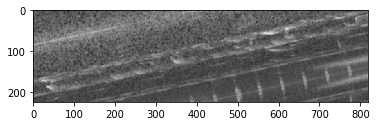

In [59]:
data__ = data_.to('cpu').detach().numpy().copy()
plt.figure()
plt.imshow(np.moveaxis(data__[5], 0, 2))

In [19]:
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.001)

In [20]:
early_stop_callback = EarlyStopping(
   monitor='valid_epoch_loss',
   min_delta=0.00,
   patience=5,
   verbose=True,
   mode='min'
)

In [21]:
model = LitModule()

Using cache found in /home/user/.cache/torch/hub/zhanghang1989_ResNeSt_master


In [22]:
# most basic trainer, uses good defaults
trainer = pl.Trainer(
    max_epochs=EPOCH,
    default_root_dir=OUTPUT_DIR,
    gpus=1,
    callbacks=[early_stop_callback]
)
trainer.fit(model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | encoder   | ResNet            | 28.6 M
1 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
28.6 M    Trainable params
0         Non-trainable params
28.6 M    Total params
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


valid_epoch_loss =  tensor(1.3642, device='cuda:0')


/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)
/home/user/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


valid_epoch_loss =  tensor(1.3473, device='cuda:0')


valid_epoch_loss =  tensor(1.3148, device='cuda:0')


valid_epoch_loss =  tensor(1.2276, device='cuda:0')


valid_epoch_loss =  tensor(1.1485, device='cuda:0')


valid_epoch_loss =  tensor(1.1067, device='cuda:0')


valid_epoch_loss =  tensor(1.0719, device='cuda:0')


valid_epoch_loss =  tensor(1.0127, device='cuda:0')


valid_epoch_loss =  tensor(0.9667, device='cuda:0')


valid_epoch_loss =  tensor(0.9360, device='cuda:0')


valid_epoch_loss =  tensor(0.8996, device='cuda:0')


valid_epoch_loss =  tensor(0.8375, device='cuda:0')


valid_epoch_loss =  tensor(0.8169, device='cuda:0')


valid_epoch_loss =  tensor(0.7644, device='cuda:0')


valid_epoch_loss =  tensor(0.6855, device='cuda:0')


valid_epoch_loss =  tensor(0.6837, device='cuda:0')


valid_epoch_loss =  tensor(0.6633, device='cuda:0')


valid_epoch_loss =  tensor(0.6636, device='cuda:0')


valid_epoch_loss =  tensor(0.6395, device='cuda:0')


valid_epoch_loss =  tensor(0.6482, device='cuda:0')


valid_epoch_loss =  tensor(0.6182, device='cuda:0')


valid_epoch_loss =  tensor(0.6406, device='cuda:0')


valid_epoch_loss =  tensor(0.5877, device='cuda:0')


valid_epoch_loss =  tensor(0.5799, device='cuda:0')


valid_epoch_loss =  tensor(0.6704, device='cuda:0')


valid_epoch_loss =  tensor(0.6174, device='cuda:0')


valid_epoch_loss =  tensor(0.5208, device='cuda:0')


valid_epoch_loss =  tensor(0.6044, device='cuda:0')


valid_epoch_loss =  tensor(0.5558, device='cuda:0')


valid_epoch_loss =  tensor(0.6347, device='cuda:0')


valid_epoch_loss =  tensor(0.5926, device='cuda:0')


valid_epoch_loss =  tensor(0.7994, device='cuda:0')



1

In [23]:
torch.save(model.state_dict(), OUTPUT_DIR + 'model')